## Описание набора данных
Для выполнения лабораторной работы, как и в предыдущих лабораторных, используется набор данных **Automobile Dataset** (файл `Automobile.csv`, источник: Kaggle – Automobile Dataset).

Данные содержат информацию о характеристиках автомобилей: происхождении, мощности двигателя, массе, ускорении, объёме двигателя, расходе топлива и т.д.

## 1. Импорт библиотек и загрузка данных

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    roc_auc_score,
    roc_curve
)

%matplotlib inline

data = pd.read_csv("Automobile.csv")
print(data.head())

                        name   mpg  cylinders  displacement  horsepower  \
0  chevrolet chevelle malibu  18.0          8         307.0       130.0   
1          buick skylark 320  15.0          8         350.0       165.0   
2         plymouth satellite  18.0          8         318.0       150.0   
3              amc rebel sst  16.0          8         304.0       150.0   
4                ford torino  17.0          8         302.0       140.0   

   weight  acceleration  model_year origin  
0    3504          12.0          70    usa  
1    3693          11.5          70    usa  
2    3436          11.0          70    usa  
3    3433          12.0          70    usa  
4    3449          10.5          70    usa  


## 2. Оценка пригодности датасета для классификации

### 2.1. Выбор целевого атрибута (метки)
В датасете есть категориальный атрибут **origin**, который отражает регион происхождения автомобиля.
Он принимает три значения: `usa`, `japan`, `europe`. Следовательно, `origin` подходит как **целевая метка класса**.

### 2.2. Проверка сбалансированности классов
Посчитаем количество объектов каждого класса и их долю.

In [5]:
class_counts = data["origin"].value_counts()
class_share = data["origin"].value_counts(normalize=True) * 100

print("Количество по классам:\n", class_counts, "\n")
print("Доли классов (%):\n", class_share.round(2))

Количество по классам:
 origin
usa       249
japan      79
europe     70
Name: count, dtype: int64 

Доли классов (%):
 origin
usa       62.56
japan     19.85
europe    17.59
Name: proportion, dtype: float64


**Вывод по сбалансированности:**
Класс `usa` доминирует (примерно ~60%+), классы `japan` и `europe` представлены заметно меньше.
Это означает, что датасет **несбалансирован**, поэтому при оценке качества важно смотреть не только Accuracy,
но и **macro Precision/Recall/F1**, так как они учитывают качество по каждому классу равновесно.

## 3. Очистка и подготовка данных

### 3.1. Удаление дубликатов




In [6]:
data = data.drop_duplicates()

### 3.2. Проверка пропусков

In [7]:
print("Пропуски по столбцам:\n", data.isna().sum())

Пропуски по столбцам:
 name            0
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64


В наборе данных встречаются пропуски (чаще всего в `horsepower`).
Для корректного обучения моделей пропуски будут заполнены медианой (импутация).

## 4. Подготовка признаков и целевого столбца

В качестве признаков берем числовые характеристики.
Столбец name исключаем (это текстовый идентификатор модели и не является полезным числовым признаком).

In [8]:
X = data.drop(columns=["origin", "name"])
y = data["origin"]

print("Форма X:", X.shape)
print("Классы y:", y.unique())

Форма X: (398, 7)
Классы y: ['usa' 'japan' 'europe']


## 5. Разделение на обучающую и тестовую выборки
Данные делятся на train/test в пропорции 70/30.
Используем `stratify=y`, чтобы доли классов в train и test были одинаковыми.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (278, 7) Test: (120, 7)


## 6. Обучение модели kNN

Для kNN важно масштабирование признаков (StandardScaler), иначе признаки с большим масштабом (например `weight`)
будут доминировать при вычислении расстояний.

Pipeline для kNN:
- заполнение пропусков медианой
- стандартизация признаков
- классификатор kNN

In [10]:
knn_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=7, weights="distance"))
])

knn_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. I

## 7. Обучение модели дерева решений

Дерево решений не требует масштабирования.
Для уменьшения переобучения зададим ограничения: `max_depth` и `min_samples_leaf`.

Pipeline для дерева:
- заполнение пропусков медианой
- DecisionTreeClassifier

In [11]:
tree_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(
        random_state=42,
        max_depth=5,
        min_samples_leaf=5
    ))
])

tree_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a feat

## 8. Оценка качества моделей

Будем считать:
- Accuracy
- Precision / Recall / F1 (macro и weighted)
- ROC-AUC (для многоклассовой классификации через One-vs-Rest)

In [12]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

    classes = model.classes_
    y_bin = label_binarize(y_test, classes=classes)
    y_proba = model.predict_proba(X_test)

    roc_auc = roc_auc_score(
        y_bin, y_proba,
        average="macro",
        multi_class="ovr"
    )

    return {
        "Accuracy": acc,
        "Precision_macro": p_macro,
        "Recall_macro": r_macro,
        "F1_macro": f1_macro,
        "F1_weighted": f1_w,
        "ROC_AUC_macro": roc_auc
    }, y_pred

knn_metrics, knn_pred = evaluate(knn_model, X_test, y_test)
tree_metrics, tree_pred = evaluate(tree_model, X_test, y_test)

knn_metrics, tree_metrics

({'Accuracy': 0.675,
  'Precision_macro': 0.5694444444444445,
  'Recall_macro': 0.5722222222222223,
  'F1_macro': 0.5649016363302078,
  'F1_weighted': 0.6764202978488693,
  'ROC_AUC_macro': 0.8531775793650794},
 {'Accuracy': 0.7416666666666667,
  'Precision_macro': 0.6486404873501648,
  'Recall_macro': 0.6838095238095239,
  'F1_macro': 0.658838150235005,
  'F1_weighted': 0.7582615703753538,
  'ROC_AUC_macro': 0.8831534692159693})

### 8.1. Отчёт классификации (Precision/Recall/F1 по каждому классу)

In [13]:
print("kNN classification report:\n")
print(classification_report(y_test, knn_pred))

print("\nDecision Tree classification report:\n")
print(classification_report(y_test, tree_pred))

kNN classification report:

              precision    recall  f1-score   support

      europe       0.44      0.33      0.38        21
       japan       0.44      0.58      0.50        24
         usa       0.83      0.80      0.82        75

    accuracy                           0.68       120
   macro avg       0.57      0.57      0.56       120
weighted avg       0.68      0.68      0.68       120


Decision Tree classification report:

              precision    recall  f1-score   support

      europe       0.46      0.57      0.51        21
       japan       0.52      0.67      0.58        24
         usa       0.97      0.81      0.88        75

    accuracy                           0.74       120
   macro avg       0.65      0.68      0.66       120
weighted avg       0.79      0.74      0.76       120



### 8.2. Сравнительная таблица метрик

In [14]:
comparison = pd.DataFrame([knn_metrics, tree_metrics], index=["kNN", "Decision Tree"])
comparison

,Accuracy,Precision_macro,Recall_macro,F1_macro,F1_weighted,ROC_AUC_macro
kNN,0.675000,0.569444,0.572222,0.564902,0.676420,0.853178
Decision Tree,0.741667,0.648640,0.683810,0.658838,0.758262,0.883153


## 9. ROC-кривые (One-vs-Rest) для kNN и дерева решений

Так как классов три, строим ROC отдельно для каждого класса (OvR):
- рассматриваем класс как "1", остальные как "0"
- строим ROC по вероятностям predict_proba

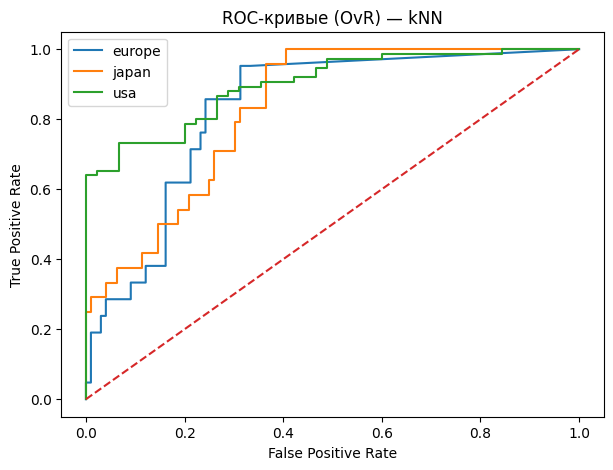

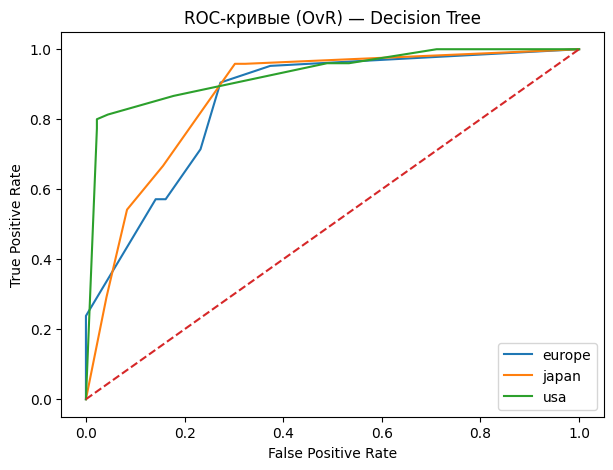

In [15]:
def plot_multiclass_roc(model, X_test, y_test, title):
    classes = model.classes_
    y_bin = label_binarize(y_test, classes=classes)
    y_proba = model.predict_proba(X_test)

    plt.figure(figsize=(7,5))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f"{cls}")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

plot_multiclass_roc(knn_model, X_test, y_test, "ROC-кривые (OvR) — kNN")
plot_multiclass_roc(tree_model, X_test, y_test, "ROC-кривые (OvR) — Decision Tree")

## 10. Объяснение результатов

1) **Дерево решений** часто показывает более высокие значения Accuracy и F1, потому что:
- умеет находить нелинейные правила (например, комбинации `weight`, `cylinders`, `displacement`),
- автоматически выделяет информативные пороги по признакам.

2) **kNN** зависит от расстояний в пространстве признаков:
- требует стандартизации,
- может ошибаться при перекрытии классов (когда автомобили разных регионов имеют похожие характеристики),
- при дисбалансе чаще “тянется” к доминирующему классу `usa`.

3) **Почему важно смотреть macro-F1:**
Из-за доминирования `usa` метрика Accuracy может выглядеть высокой даже тогда,
когда модель хуже распознаёт `japan` и `europe`.
Macro-метрики показывают среднее качество по классам без учета их размера.

4) **ROC-AUC:**
ROC-AUC (OvR) показывает, насколько хорошо модель ранжирует вероятности классов.
Даже при ошибках в жёстком выборе класса (argmax), ROC-AUC может быть высоким,
если модель в целом корректно “отличает” классы по вероятностям.

## Итоговый вывод о пригодности датасета

Датасет **пригоден для задачи классификации**, потому что:
- есть естественная целевая метка `origin` (3 класса),
- есть набор числовых признаков, потенциально связанных с происхождением автомобиля.

Однако датасет имеет особенности:
- классы **несбалансированы** (доминирует `usa`),
- есть пропуски (например, `horsepower`), требующие обработки.

После предобработки (импутации и масштабирования для kNN) датасет корректно используется для сравнения kNN и дерева решений.